<h1>Segmentazione</h1>
<h2>Bianchi Luca</h2>

<h3>Introduzione e Immagini usate</h3>

<p>
Lo scopo di questo lavoro è di approfondire il funzionamento degli algoritmi
active contour ed edge detection, verificarne il funzionamento in casi semplici
per "riscaldamento", e provare ad applicarli in seguito in uno scenario più complesso.
Infine, provare a combinare i due metodi per cercare di migliorare le prestazioni
dell'algoritmo di active contour dandogli in input un'immagine generata dall'algoritmo
di edge detection.
</p>
<p>
Ho deciso di usare, nello specifico, un'immagine di una pallina da tennis come caso
semplice, mentre per lo scenario avanzato ho selezionato un'immagine notturna di
uno scenario urbano. Nello specifico, ci interessa riuscire ad ottenere in contorno
del ciclista visibile in basso a destra, figura che risulta anche essere in leggero movimento
</p>

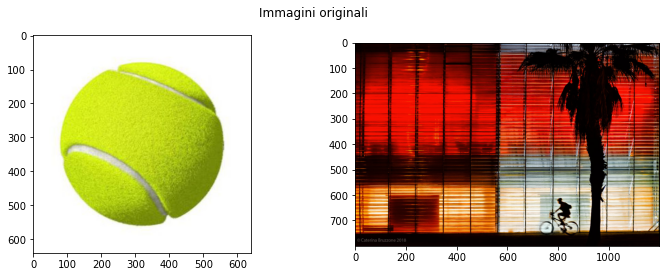

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from skimage.filters import gaussian

ballImg = plt.imread('./tennis_ball.jpg')
moveImg = plt.imread('./movement.jpg')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Immagini originali")
ax = axes.ravel()
_ = ax[0].imshow(ballImg)
_ = ax[1].imshow(moveImg)

#Da qui in poi non useremo più immagini a colori
plt.gray()

<h3>Active contour</h3>


In [2]:
gray_ball = rgb2gray(ballImg)

#Prepariamo delle matrici di inizializzazione per circoscrivere
#la zona di cui vogliamo rilevare il contorno
s = np.linspace(0, 2*np.pi, 400)
x = 320 + 100*np.cos(s)
y = 280 + 100*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(gray_ball, 3), init,
                       alpha=-0.015, beta=10, gamma=0.001, max_px_move=5)

In [3]:
x = 320 + 300*np.cos(s)
y = 320 + 300*np.sin(s)
init2 = np.array([x, y]).T

snake2 = active_contour(gray_ball, init2, beta=10)

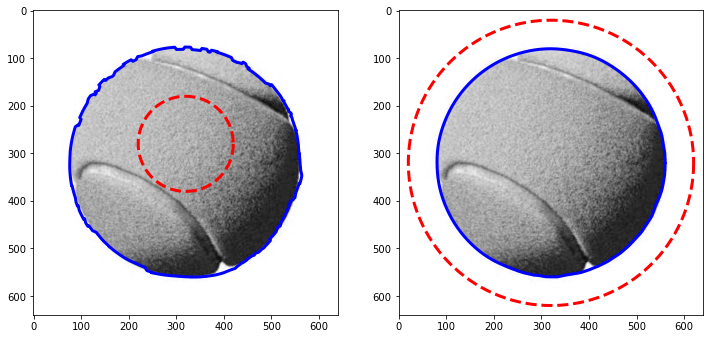

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
for elem in ax:
    elem.imshow(gray_ball)
_ = ax[0].plot(init[:, 0], init[:, 1], '--r', lw=3)
_ = ax[1].plot(init2[:, 0], init2[:, 1], '--r', lw=3)
_ = ax[0].plot(snake[:, 0], snake[:, 1], '-b', lw=3)
_ = ax[1].plot(snake2[:, 0], snake2[:, 1], '-b', lw=3)

È facile osservare come l'algoritmo usato, che utilizza uno "snake" (una linea composta
da punti equidistanti che si muovono in varie iterazioni), funzioni in modo decisamente
migliore quando si tratta di lavorare restringendosi piuttosto che espandendosi. Inoltre,
sembrerebbe non rilevare le linee interne come bordi, passando semplicemente oltre fino ad
arrivare al bordo esterno della sfera.
Passando ora ad un caso d'uso più probabile, ossia per analizzare immagini in tempo reale,
vediamo come si comporta l'algoritmo su un'immagine di uno scenario urbano, concentrandoci
principalmente sul ciclista che si vede in foto

In [5]:
moveImgBn = rgb2gray(moveImg[520:, 620:1020])

x = 210 + 12*np.cos(s)
y = 150 + 12*np.sin(s)
init = np.array([x, y]).T

snake = active_contour(gaussian(moveImgBn, 2), init)

In [6]:
x = 190 + 110*np.cos(s)
y = 165 + 100*np.sin(s)
init2 = np.array([x, y]).T

snake2 = active_contour(gaussian(moveImgBn, 2), init2)

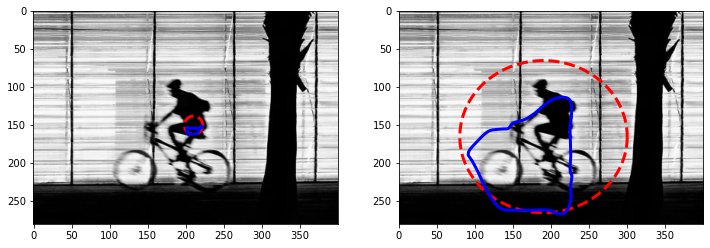

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
for elem in ax:
    elem.imshow(moveImgBn)
_ = ax[0].plot(init[:, 0], init[:, 1], '--r', lw=3)
_ = ax[1].plot(init2[:, 0], init2[:, 1], '--r', lw=3)
_ = ax[0].plot(snake[:, 0], snake[:, 1], '-b', lw=3)
_ = ax[1].plot(snake2[:, 0], snake2[:, 1], '-b', lw=3)

Osserviamo come in nessuno dei due casi si riesca a ottenere
un contorno attorno alla figura presa in esame. Non sono in grado di
stabilire, però, se questo sia dovuto a un uso sbagliato da parte mia
della libreria, o se si tratti di effettivi limiti implementativi dell'algoritmo.
Parte del problema è probabilmente dato dall'immagine stessa: sono presenti molti bordi, alcuni
più nitidi di altri, e questo probabilmente porta l'algoritmo a fallire nel riconoscere la forma da
circondare

<h3>Edge Detection</h3>

Proviamo ora a implementare un altro metodo per la segmentazione delle immagini
basato sulla rilevazione dei bordi attraverso filtri convoluzionali, usando applicazioni
i filtri di Sobel, Prewitt e Laplace (combinato con filtro gaussiano per mitigare
il rumore) e confrontando i risultati ottenuti.

In [8]:
def apply_kernel(kernel, img, threshold = 0):
    rows = len(img)
    col = len(img[0])
    res = np.zeros((rows-2, col-2))

    for r in range(0, rows - 2):
        for c in range(0, col - 2):
            matrix = img[r:r+3, c:c+3]
            s1 = np.sum(np.sum(kernel*matrix))
            s2 = np.sum(np.sum(kernel.T*matrix))
            res[r, c] = np.sqrt(s1**2+s2**2)
            if res[r, c] < threshold:
                res[r, c] = 0
    return res

def apply_laplace(img, threshold = 0):
    rows = len(img)
    col = len(img[0])
    res = np.zeros((rows-1, col-1))
    kernel = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])

    for r in range(0, rows - 2):
        for c in range(0, col - 2):
            matrix = img[r:r+3, c:c+3]
            res[r+1, c+1] = np.sum(np.sum(kernel*matrix))
            if res[r+1, c+1] < threshold:
                res[r+1, c+1] = 0
    return res

gray_ball = rgb2gray(ballImg)
sobel_kernel = np.array([np.array([1, 0, -1]), np.array([2, 0, -2]), np.array([1, 0, -1])])
prewitt_kernel = np.array([np.array([-1, 0, 1]), np.array([-1, 0, 1]), np.array([-1, 0, 1])])

def generate_img_dict(img):
    gray_img = rgb2gray(img)
    tennis_ball = [{"name": "Originale", "img": gray_img},
               {"name": "Sobel", "img": apply_kernel(sobel_kernel, gray_img, .25)},
               {"name": "Prewitt", "img": apply_kernel(prewitt_kernel, gray_img, .125)},
               {"name": "Laplace", "img": apply_laplace(gaussian(gray_img, 3), .005)}]
    return tennis_ball

Visualizziamo i risultati dell'esecuzione sulla pallina da tennis

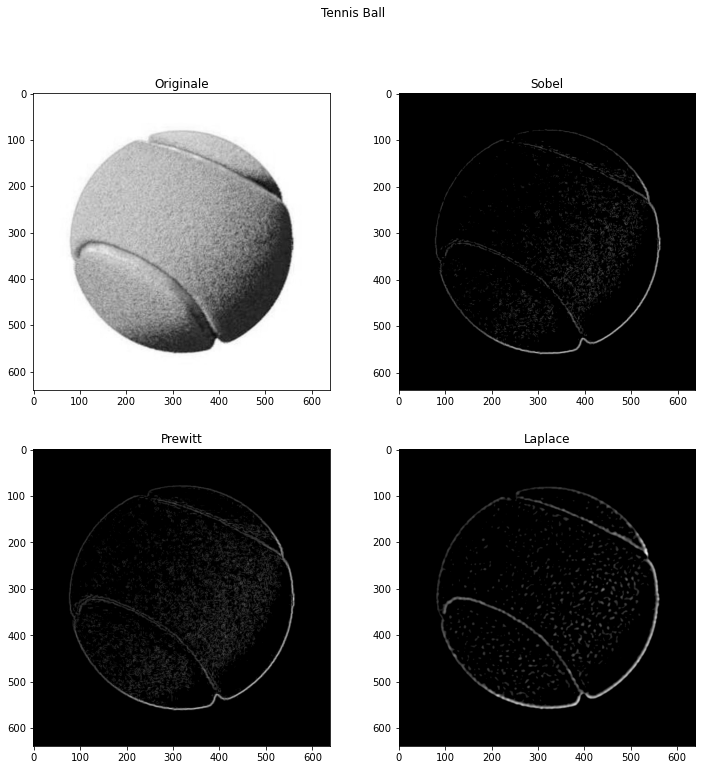

In [9]:
tbcp = generate_img_dict(ballImg)
tbcp.reverse()
f, axes = plt.subplots(2, 2, figsize=(12, 12))
f.suptitle("Tennis Ball")
for ax in axes:
    for elem in ax:
        n = tbcp.pop()
        elem.imshow(n['img'])
        elem.set_title(n['name'])

Come si può notare, e come era auspicabile, mentre i filtri di Sobel e Prewitt, una volta
applicati due volte (come filtro e filtro<sup>T</sup>) restituiscono un risultato
soddisfacente, col filtro di Sobel che risulta essere più "sensibile" di Prewitt, utilizzare
Laplace permette di rilevare i bordi in modo più preciso, a scapito di una maggiore sensibilità
al rumore. Ovviamente, siccome l'operatore Laplaciano è vicino all'essere inutilizzabile
se non combinato con altre tecniche che permettano di ridurre il rumore nell'immagine di partenza,
il costo computazionale risulterà essere maggiore rispetto agli altri due filtri, che non
necessitano di pre-produzione.

Proviamo ora ad applicare i filtri in uno scenario più complesso e visualizzarne i risultati

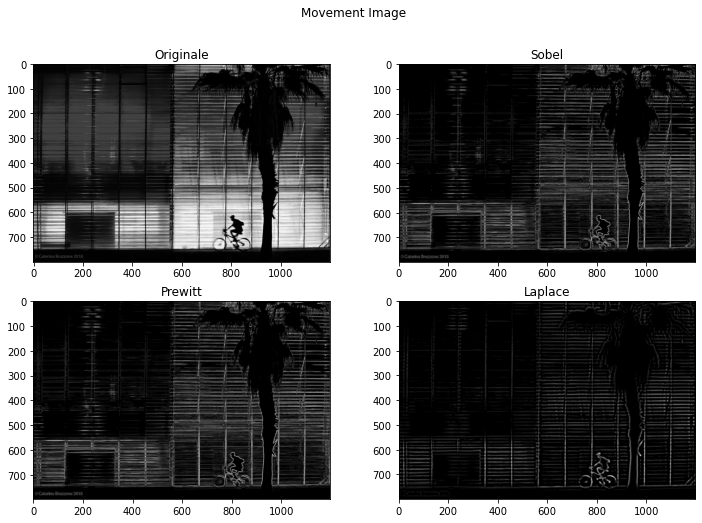

In [10]:
mvimg = generate_img_dict(moveImg)
mvimg.reverse()
f , axes = plt.subplots(2, 2, figsize=(12, 8))
f.suptitle("Movement Image")
for ax in axes:
    for elem in ax:
        n = mvimg.pop()
        elem.imshow(n['img'])
        elem.set_title(n['name'])



In questo caso, molto probabilmente grazie all'aiuto dato dal filtro gaussiano,
Laplace risulta essere il filtro migliore nel rilevare la sagoma a cui siamo interessati,
sebbene non abbia la miglire nitidezza, riducendo al minimo il "rumore" di fondo presente nelle altre operazioni.

Proviamo ora a combinare i due metodi e proviamo a vedere se l'algoritmo di active
contour riesce a lavorare meglio sugli output prodotti dall'edge detection

<h3>Applicazione combinata</h3>

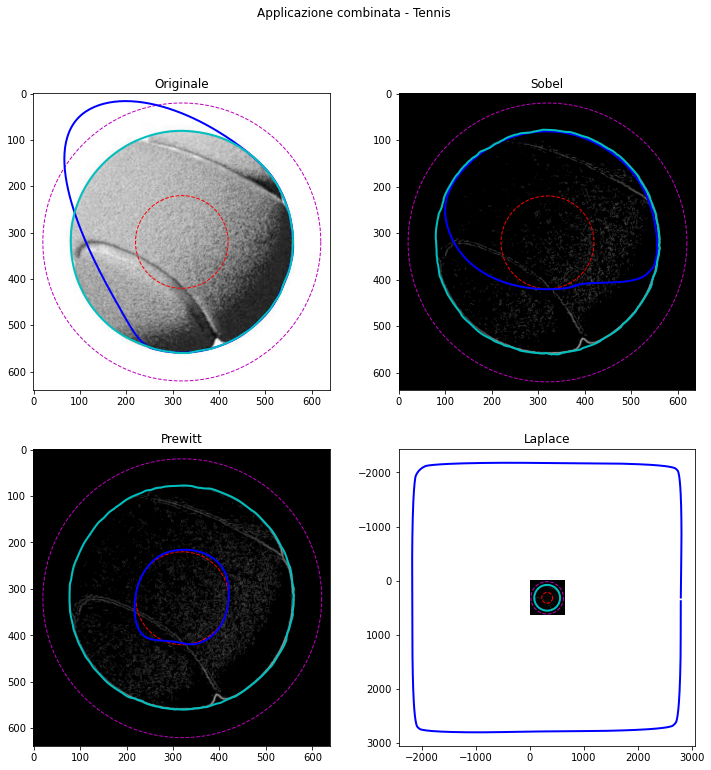

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
tbcp = generate_img_dict(ballImg)
tbcp.reverse()
x = 320 + 100*np.cos(s)
y = 320 + 100*np.sin(s)
init = np.array([x, y]).T
init2 = np.array([x + 200*np.cos(s), y + 200*np.sin(s)]).T
fig.suptitle("Applicazione combinata - Tennis")

for ax in axes:
    for a in ax:
        n = tbcp.pop()
        snake = active_contour(gaussian(n['img'], 3), init,
                               alpha=-.0215, beta=10, gamma=.001)
        snake2 = active_contour(n['img'], init2, beta=10)
        a.imshow(n['img'])
        a.set_title(n['name'])
        a.plot(init[:, 0], init[:, 1], '--r', lw=1)
        a.plot(init2[:, 0], init2[:, 1], '--m', lw=1)
        a.plot(snake[:, 0], snake[:, 1], '-b', lw=2)
        a.plot(snake2[:, 0], snake2[:, 1], '-c', lw=2)

Come ci aspettavamo, il risultato dell'esecuzione in espansione (coppia rosso - blu) non sembra dare frutti.
L'esecuzione in chiusura (coppia magenta - ciano), invece, si comporta come sull'immagine base,
identificando correttamente l'oggetto.

Passiamo quindi al caso d'interesse, eseguendo solo l'algoritmo in chiusura

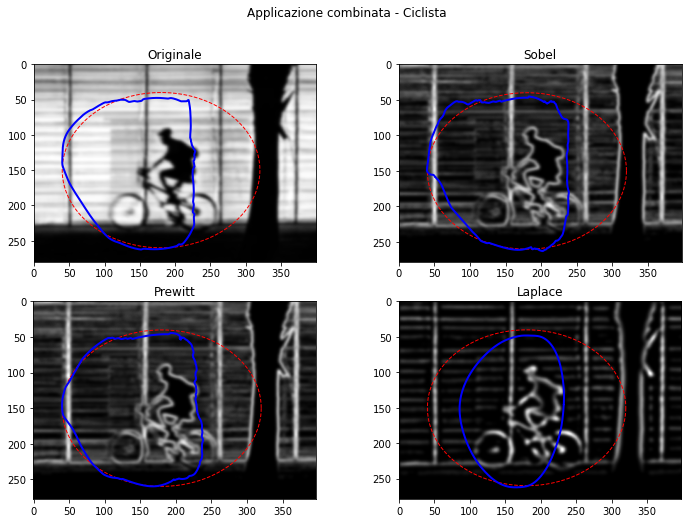

In [12]:
mvimg = generate_img_dict(moveImg[520:, 620:1020])
mvimg.reverse()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
x = 180 + 140*np.cos(s)
y = 150 + 110*np.sin(s)
init = np.array([x, y]).T
fig.suptitle("Applicazione combinata - Ciclista")

for ax in axes:
    for a in ax:
        n = mvimg.pop()
        n['img'] = gaussian(n['img'], 2)
        a.imshow(n['img'])
        snake = active_contour(n['img'], init,
                               beta = 10, gamma=.0005,
                               max_iterations=10**4)
        a.set_title(n['name'])
        a.plot(init[:, 0], init[:, 1], '--r', lw=1)
        a.plot(snake[:, 0], snake[:, 1], '-b', lw=2)

<h3>Conclusione</h3>

Nemmeno combinando i due metodi e applicando un filtro gaussiano all'input riusciamo a ottenere
un risultato soddisfacente. Il "rumore" attorno al nostro ciclista crea comunque una situazione
ben lontana dall'essere ideale. Il risultato più vicino al desiderato è restituito
dal Laplaciano, che restituisce un immagine dallo sfondo tendenzialmente più uniforme e, di conseguenza,
ha meno problemi nell'individuare correttamente i bordi del soggetto.


